In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
import requests

In [2]:
# elevation data https://en-au.topographic-map.com/place-q9knh/Florida/
# Data is in meters
data = {
    'NAME': ['Osceola', 'Orange', 'Okeechobee', 'Palm Beach', 'Putnam', 'Lake', 
               'Lafayette', 'Indian River', 'Hardee', 'Glades', 'Gilchrist', 'Gulf', 'Pinellas', 'Highlands',
               'Hillsborough', 'Hendry', 'Hernando', 'Union', 'Taylor', 'Collier', 'DeSoto', 'Dixie', 'Sarasota',
               'Seminole', 'St. Lucie', 'Sumter', 'Levy', 'Lee', 'Wakulla', 'St. Johns', 'Volusia', 'Pasco', 'Polk',
               'Franklin', 'Flagler', 'Brevard', 'Bradford', 'Alachua', 'Clay', 'Broward', 'Charlotte', 'Citrus',
               'Monroe', 'Miami-Dade', 'Martin', 'Marion', 'Manatee', 'Jackson', 'Holmes', 'Okaloosa', 'Jefferson', 
               'Hamilton', 'Washington', 'Suwannee', 'Columbia', 'Santa Rosa', 'Madison', 'Liberty', 'Leon', 
               'Escambia', 'Duval', 'Gadsden', 'Bay', 'Baker', 'Walton', 'Calhoun', 'Nassau' ],
    'AVG ELEVATION': [19, 112, 12, 5, 17, 56, 22, 8, 8, 12, 19, 5, 4, 22, 20, 8, 18, 41, 8, 5, 18, 7, 7, 14, 8,
                     27, 11, 5, 10, 6, 8, 18, 33, 4, 6, 9, 45, 33, 29, 5, 10, 14, 1, 3, 6, 24, 13, 44, 39, 37, 23,
                     37, 31, 27, 36, 32, 33, 27, 38, 30, 11, 50, 13, 40, 31, 31, 13]
}

elevation_df = pd.DataFrame(data)

print(elevation_df)

          NAME  AVG ELEVATION
0      Osceola             19
1       Orange            112
2   Okeechobee             12
3   Palm Beach              5
4       Putnam             17
..         ...            ...
62         Bay             13
63       Baker             40
64      Walton             31
65     Calhoun             31
66      Nassau             13

[67 rows x 2 columns]


In [3]:
url='https://api.census.gov/data/2020/dec/dhc'
params = {
    "get": 'NAME,P1_001N', 
    "for": "county:*",
    "in": "state:12",
    "key": "5520cc76d77e35f1499e60417bf7c8b45c69f66a"}
response = requests.get(url,params=params)
total_population=pd.DataFrame(response.json()[1:], columns=response.json()[0])
total_population['NAME']= total_population['NAME'].str.split(' ').str[0]
total_population['P1_001N'].unique().sort()

In [4]:
# Income data
income_data = pd.read_excel('/Users/ehast/Downloads/AllCounties_Data.xlsx')
# Rename columns for clarity
income_data.rename(columns={
    'Median Household Income, Dollars, 2010': 'NAME',
    'Unnamed: 1': 'Income/year'
}, inplace=True)

In [5]:
# Drop the first two row
income_data = income_data.drop(0)
income_data = income_data.drop(1)
# Reset the index
income_data.reset_index(drop=True, inplace=True)

In [6]:
income_data.head()

,NAME,Income/year
0,Alachua,40644
1,Baker,47276
2,Bay,47770
3,Bradford,41126
4,Brevard,49523


In [7]:
merged_data = total_population.merge(income_data, on='NAME', how='inner')
merged_data.head()

,NAME,P1_001N,state,county,Income/year
0,Alachua,278468,12,001,40644
1,Baker,28259,12,003,47276
2,Bay,175216,12,005,47770
3,Bradford,28303,12,007,41126
4,Brevard,606612,12,009,49523


In [8]:
merged_data['Income/year'] = merged_data['Income/year'].astype(float)
merged_data['P1_001N'] = merged_data['P1_001N'].astype(float)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         62 non-null     object 
 1   P1_001N      62 non-null     float64
 2   state        62 non-null     object 
 3   county       62 non-null     object 
 4   Income/year  62 non-null     float64
dtypes: float64(2), object(3)
memory usage: 2.6+ KB


In [9]:
merged_data = merged_data.merge(elevation_df, on='NAME', how='inner')
merged_data = merged_data.drop(['state','county'], axis=1)

In [10]:
merged_data['elevation_post_rise'] = merged_data['AVG ELEVATION']-3.92

In [11]:
merged_data[merged_data['NAME'] == 'Miami-Dade']

,NAME,P1_001N,Income/year,AVG ELEVATION,elevation_post_rise
41,Miami-Dade,2701767.0,43605.0,3,-0.92


In [12]:
bins = [0, 50000, 100000, 500000, 1000000, 2500000, 100000000000]
labels = [0, 1, 2, 3, 4, 5]
merged_data['Population_level'] = pd.cut(merged_data["P1_001N"], bins = bins, labels = labels, include_lowest= True)
merged_data.head()

,NAME,P1_001N,Income/year,AVG ELEVATION,elevation_post_rise,Population_level
0,Alachua,278468.0,40644.0,33,29.08,2
1,Baker,28259.0,47276.0,40,36.08,0
2,Bay,175216.0,47770.0,13,9.08,2
3,Bradford,28303.0,41126.0,45,41.08,0
4,Brevard,606612.0,49523.0,9,5.08,3


In [13]:
merged_data['Income/year'].unique()

array([40644., 47276., 47770., 41126., 49523., 51694., 31699., 45037.,
       37933., 61185., 58106., 38214., 35979., 32312., 49463., 43573.,
       48090., 36490., 35728., 37039., 39429., 39178., 37613., 37466.,
       37298., 42011., 34946., 49536., 32247., 38257., 41359., 46445.,
       46477., 50014., 44490., 35737., 40777., 37459., 47812., 40339.,
       53210., 43605., 53821., 58712., 54242., 38339., 50138., 46328.,
       44228., 45258., 43946., 34645., 49388., 58971., 43079., 36352.,
       37408., 41794., 44400., 53301., 47273., 36216.])

In [14]:
bins = [0, 30000, 35000, 40000, 45000, 50000, 100000000000]
labels = [0, 1, 2, 3, 4, 5]
merged_data['Income_level'] = pd.cut(merged_data["Income/year"], bins = bins, labels = labels, include_lowest= True)
merged_data.head()

,NAME,P1_001N,Income/year,AVG ELEVATION,elevation_post_rise,Population_level,Income_level
0,Alachua,278468.0,40644.0,33,29.08,2,3
1,Baker,28259.0,47276.0,40,36.08,0,4
2,Bay,175216.0,47770.0,13,9.08,2,4
3,Bradford,28303.0,41126.0,45,41.08,0,3
4,Brevard,606612.0,49523.0,9,5.08,3,4


In [15]:
bins = [-5, 0, 20, 40, 60, 80, 1000]
labels = [0, 1, 2, 3, 4, 5]
merged_data['Elevation_level'] = pd.cut(merged_data["elevation_post_rise"], bins = bins, labels = labels, include_lowest= True)
merged_data.head()

,NAME,P1_001N,Income/year,AVG ELEVATION,elevation_post_rise,Population_level,Income_level,Elevation_level
0,Alachua,278468.0,40644.0,33,29.08,2,3,2
1,Baker,28259.0,47276.0,40,36.08,0,4,2
2,Bay,175216.0,47770.0,13,9.08,2,4,1
3,Bradford,28303.0,41126.0,45,41.08,0,3,3
4,Brevard,606612.0,49523.0,9,5.08,3,4,1


In [16]:
merged_data['Income_level'] = merged_data['Income_level'].astype('float32')
merged_data['Population_level'] = merged_data['Population_level'].astype('float32')
merged_data['Elevation_level'] = merged_data['Elevation_level'].astype('float32')

In [17]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NAME                 62 non-null     object 
 1   P1_001N              62 non-null     float64
 2   Income/year          62 non-null     float64
 3   AVG ELEVATION        62 non-null     int64  
 4   elevation_post_rise  62 non-null     float64
 5   Population_level     62 non-null     float32
 6   Income_level         62 non-null     float32
 7   Elevation_level      62 non-null     float32
dtypes: float32(3), float64(3), int64(1), object(1)
memory usage: 3.3+ KB


In [21]:
# Define weights
weights = {
    'P1_001N': 10,  # Weight for population
    'elevation_post_rise': 5,  # Weight for elevation
    'Income/year': 5  # Weight for income
}

# Calculate risk score
merged_data['risk_score'] = (
    merged_data['Population_level'] * weights['P1_001N'] + 50 -
    merged_data['Elevation_level'] * weights['elevation_post_rise'] -
    merged_data['Income_level'] * weights['Income/year']
)
merged_data.head()

,NAME,P1_001N,Income/year,AVG ELEVATION,elevation_post_rise,Population_level,Income_level,Elevation_level,risk_score
0,Alachua,278468.0,40644.0,33,29.08,2.0,3.0,2.0,45.0
1,Baker,28259.0,47276.0,40,36.08,0.0,4.0,2.0,20.0
2,Bay,175216.0,47770.0,13,9.08,2.0,4.0,1.0,45.0
3,Bradford,28303.0,41126.0,45,41.08,0.0,3.0,3.0,20.0
4,Brevard,606612.0,49523.0,9,5.08,3.0,4.0,1.0,55.0


In [22]:
merged_data[merged_data['NAME'] == 'Miami-Dade']

,NAME,P1_001N,Income/year,AVG ELEVATION,elevation_post_rise,Population_level,Income_level,Elevation_level,risk_score
41,Miami-Dade,2701767.0,43605.0,3,-0.92,5.0,3.0,0.0,85.0


array([45., 20., 55., 60., 35., 40., 25., 30., 50., 65., 85.],
      dtype=float32)

In [24]:
# Define features and target variable
X = merged_data[['Population_level', 'Income_level', 'Elevation_level']]
y = merged_data['risk_score'] # Change to risk score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X

,Population_level,Income_level,Elevation_level
0,2.0,3.0,2.0
1,0.0,4.0,2.0
2,2.0,4.0,1.0
3,0.0,3.0,3.0
4,3.0,4.0,1.0
...,...,...,...
57,0.0,3.0,2.0
58,3.0,3.0,1.0
59,0.0,5.0,1.0
60,1.0,4.0,2.0


In [27]:
# Label encode the target variable
#from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()
#le.fit(np.concatenate([y_train, y_test]))
#y_train = le.transform(y_train)
#y_test = le.transform(y_test)



# Define the DNN model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(100, activation='sigmoid')  # 3 classes: low, medium, high
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 [==============================] - 0s 137ms/step - loss: 4.5526 - accuracy: 0.1176 - val_loss: 4.4651 - val_accuracy: 0.2222
Epoch 2/50
2/2 [==============================] - 0s 8ms/step - loss: 4.4937 - accuracy: 0.1176 - val_loss: 4.4218 - val_accuracy: 0.2222
Epoch 3/50
2/2 [==============================] - 0s 8ms/step - loss: 4.4466 - accuracy: 0.1176 - val_loss: 4.3797 - val_accuracy: 0.2222
Epoch 4/50
2/2 [==============================] - 0s 8ms/step - loss: 4.3983 - accuracy: 0.1176 - val_loss: 4.3340 - val_accuracy: 0.2222
Epoch 5/50
2/2 [==============================] - 0s 8ms/step - loss: 4.3475 - accuracy: 0.1176 - val_loss: 4.2868 - val_accuracy: 0.2222
Epoch 6/50
2/2 [==============================] - 0s 9ms/step - loss: 4.2936 - accuracy: 0.1176 - val_loss: 4.2348 - val_accuracy: 0.2222
Epoch 7/50
2/2 [==============================] - 0s 8ms/step - loss: 4.2330 - accuracy: 0.1176 - val_loss: 4.1741 - val_accuracy: 0.2222
Epoch 8/50
2/2 [================

/var/folders/vh/mx4xfd715vxfvctwd1zfbjhr0000gn/T/ipykernel_1500/2269679054.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(counties_gdf.geometry.centroid.x, counties_gdf.geometry.centroid.y, counties_gdf['NAME']):


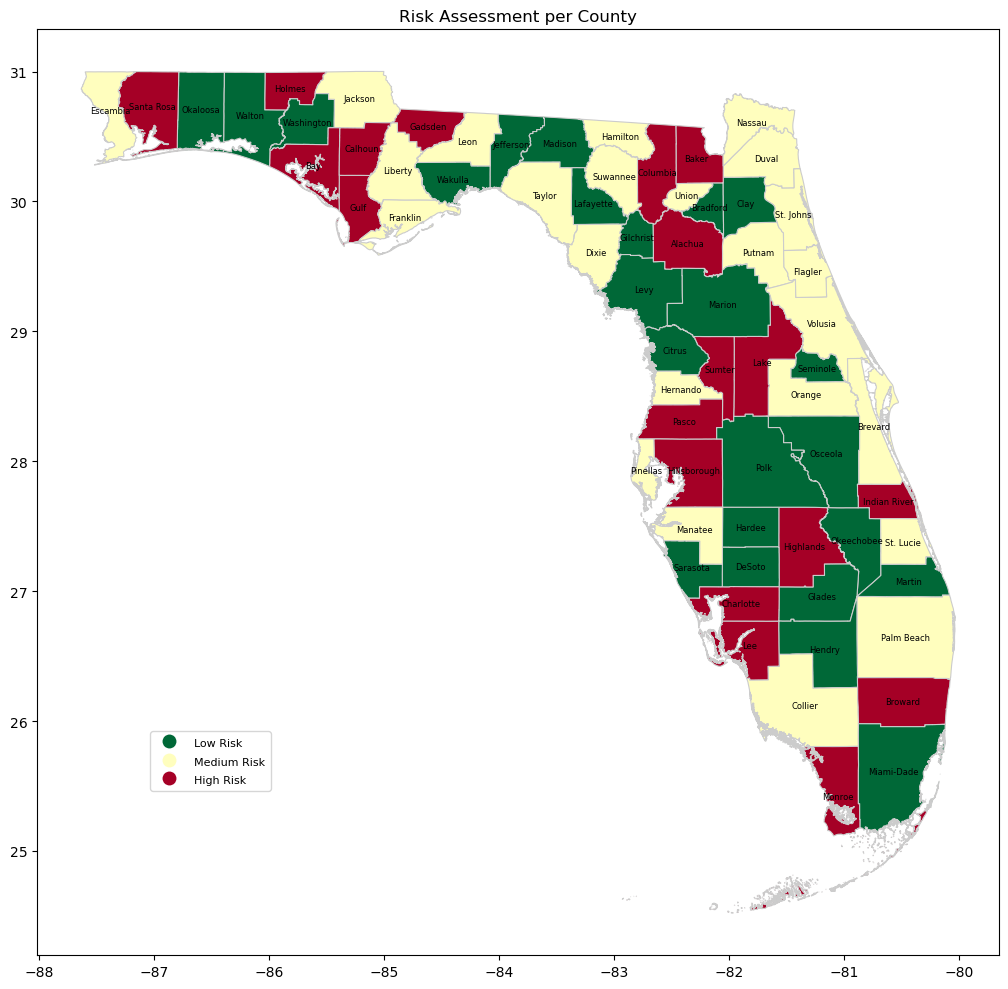

In [1]:
# Test visualization using random scores. Once the risk refinement is finished, it will plot the real risk scores.
counties_gdf = gpd.read_file("/Users/ehast/Desktop/mapdata")  

# Assigning random risk scores
np.random.seed(0)  # For reproducibility
counties_gdf['risk_score'] = np.random.choice([0, 1, 2], size=len(counties_gdf))

# Categorize the data
risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
counties_gdf['risk_category'] = pd.Categorical.from_codes(counties_gdf['risk_score'], categories=risk_categories)

# Custom colormap
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, 3))  # Red-Yellow-Green colormap reversed
cmap = plt.matplotlib.colors.ListedColormap(colors)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
counties_gdf.plot(column='risk_category', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Adding county names
for x, y, label in zip(counties_gdf.geometry.centroid.x, counties_gdf.geometry.centroid.y, counties_gdf['NAME']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center')

# Adjust the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0, 0, 0.25, 0.25))  # Adjust the bounding box to increase the size
for label in leg.get_texts():
    label.set_fontsize(8)  # Set text size
for handle in leg.legend_handles:
    handle.set_linewidth(2.0)  # Set line width

# Set title and adjust layout
ax.set_title('Risk Assessment per County')
fig.tight_layout()

plt.show()
